In [1]:
import numpy as np
import pandas as pd 
import pickle
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import nn_utils as nu
import data_utils as du
import data_augment as da
import cv_transf  as cvt

In [2]:
def get_track_data(training_path, track):
    track_path   = os.path.join(training_path, track)
    data_curves  = os.path.join(track_path, 'training.curves/')
    data_recover = os.path.join(track_path, 'training.recover/')
    data_center  = os.path.join(track_path, 'training.centered/')
    df_curves    = du.reformat_csv(data_curves,  header=False)
    df_recover   = du.reformat_csv(data_recover, header=False)
    df_center    = du.reformat_csv(data_center,  header=False)
    n_obs = len(df_center) + len(df_curves) + len(df_recover)
    s = 'Track: {} Num Center: {}, Curves: {}, Recover: {}, Total: {}'
    print(s.format(track, len(df_center),len(df_curves), len(df_recover), n_obs) )
    return {'center': df_center, 'curves': df_curves, 'recover': df_recover}
    
def combine_track_data(dict_track1, dict_track2):
    df_center  = pd.concat([dict_track1['center'],  dict_track2['center']], axis=0)
    df_curves  = pd.concat([dict_track1['curves'],  dict_track2['curves']], axis=0)
    df_recover = pd.concat([dict_track1['recover'], dict_track2['recover']], axis=0)
    df_comb = pd.concat([df_center, df_curves, df_recover],axis=0)
    return df_comb.sample(frac=1.0).reset_index(drop=True)
   
data_udacity  = './data/udacity/'
data_training = './data/training/' 
df_drive_udacity = du.reformat_csv(data_udacity, header=True)
print('Udacity Track: {}, Num Obs: {}'.format('track1', len(df_drive_udacity)))
dict_sim_track1 = get_track_data(data_training, 'track1')
dict_sim_track2 = get_track_data(data_training, 'track2')
df_drive_tracks = combine_track_data(dict_sim_track1, dict_sim_track2)
print('Total Simulator Obs Track1 + Track2: {}'.format(len(df_drive_tracks)))
df_drive_tracks.head()

Udacity Track: track1, Num Obs: 8036
Track: track1 Num Center: 3066, Curves: 3256, Recover: 1417, Total: 7739
Track: track2 Num Center: 4645, Curves: 2108, Recover: 1094, Total: 7847
Total Simulator Obs Track1 + Track2: 15586


,center,left,right,steering,throttle,brake,speed
0,./data/training/track2/training.curves/IMG/cen...,./data/training/track2/training.curves/IMG/lef...,./data/training/track2/training.curves/IMG/rig...,0.270342,0.000000,0.0,7.924408
1,./data/training/track2/training.centered/IMG/c...,./data/training/track2/training.centered/IMG/l...,./data/training/track2/training.centered/IMG/r...,-0.504570,0.044358,0.0,6.627839
2,./data/training/track1/training.curves/IMG/cen...,./data/training/track1/training.curves/IMG/lef...,./data/training/track1/training.curves/IMG/rig...,-0.030034,0.000000,0.0,5.365061
3,./data/training/track1/training.recover/IMG/ce...,./data/training/track1/training.recover/IMG/le...,./data/training/track1/training.recover/IMG/ri...,0.254017,0.000000,0.0,7.816418
4,./data/training/track2/training.centered/IMG/c...,./data/training/track2/training.centered/IMG/l...,./data/training/track2/training.centered/IMG/r...,-0.724351,0.000000,0.0,7.259079


Image Dimensions: (160, 320, 3)


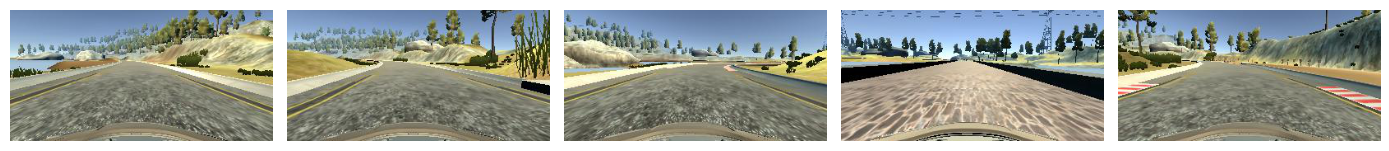

In [3]:
def set_axi_opts(axi, **kwargs):
    axi.grid(False)
    axi.get_yaxis().set_visible(False)
    axi.get_xaxis().set_ticks([])
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': 10}
    if 'title'  in kwargs: axi.set_title(kwargs['title'], **params )
    if 'xlabel' in kwargs: axi.set_xlabel(kwargs['xlabel'])

def get_image(frame, sample_idx, col='center'):
    ds_sample  = frame.ix[sample_idx]
    img_sample = ds_sample[col].strip()
    img_data = mpimg.imread(img_sample)
    return img_data
  
# sample of center images across track 1
fig, ax = plt.subplots(1, 5, figsize=(14,16))
axes = ax.flatten()
df_track1_center = dict_sim_track1['center']
rand_idxs = np.random.randint(0, len(df_track1_center),len(axes))
image_dim = get_image(df_track1_center, rand_idxs[0]).shape
print("Image Dimensions: {}".format(image_dim))
for axi, sample_idx in zip(axes, rand_idxs):
    axi.imshow(get_image(df_track1_center, sample_idx))
    set_axi_opts(axi)
plt.tight_layout()
fig.savefig('./images/camera_snapshots_centered.png', transparent=False, bbox_inches='tight')

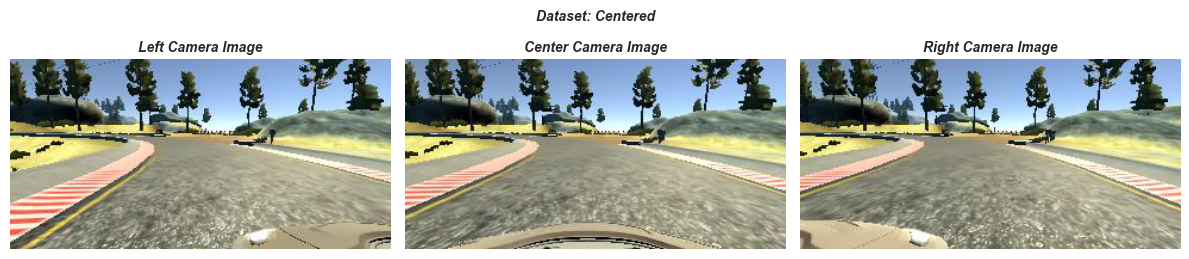

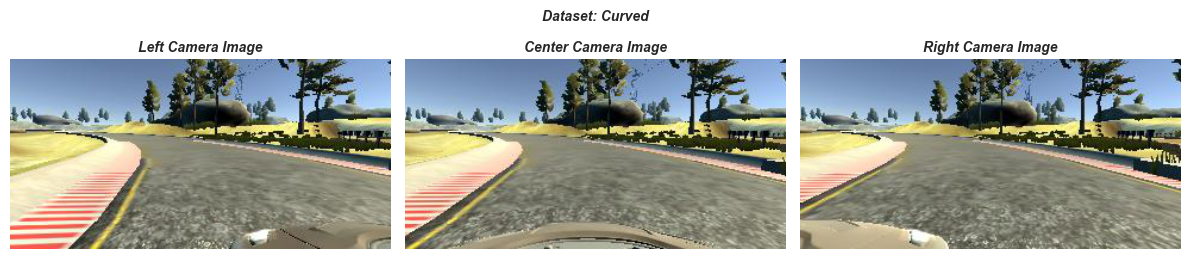

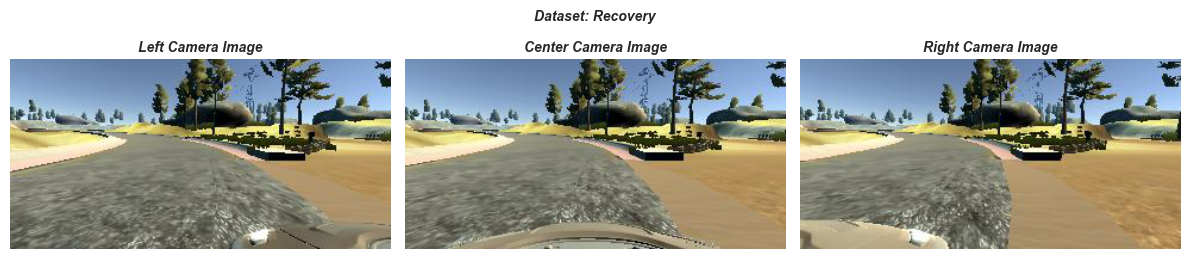

In [4]:
# sample snapshot of left, center, right instance
def plot_dataset(df_track_dataset, index, dataset_type):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,3))
    titles = ['Left Camera Image', 'Center Camera Image', 'Right Camera Image']
    ax1.imshow(get_image(df_track_dataset, index, col='left'))
    ax2.imshow(get_image(df_track_dataset, index, col='center'))
    ax3.imshow(get_image(df_track_dataset, index, col='right'))
    _ = [set_axi_opts(axi, **{'title': title}) for axi,title in zip([ax1,ax2,ax3], titles)]
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': 10}
    fig.suptitle('Dataset: {}'.format(dataset_type), **params)
    plt.tight_layout()
    path = os.path.join('images', "".join(['camera_angles_', dataset_type.lower(), '.png']) )
    fig.savefig(path, transparent=False, bbox_inches='tight')    

df_track1_center = dict_sim_track1['center'] 
df_track1_curves = dict_sim_track1['curves']
df_track1_recover = dict_sim_track1['recover']
center_idx = np.random.randint(0, len(df_track1_center), 1)[0]
plot_dataset(df_track1_center,  center_idx, 'Centered')
plot_dataset(df_track1_curves,  np.argmin(df_track1_curves.steering),  'Curved')
plot_dataset(df_track1_recover, np.argmin(df_track1_recover.steering), 'Recovery')

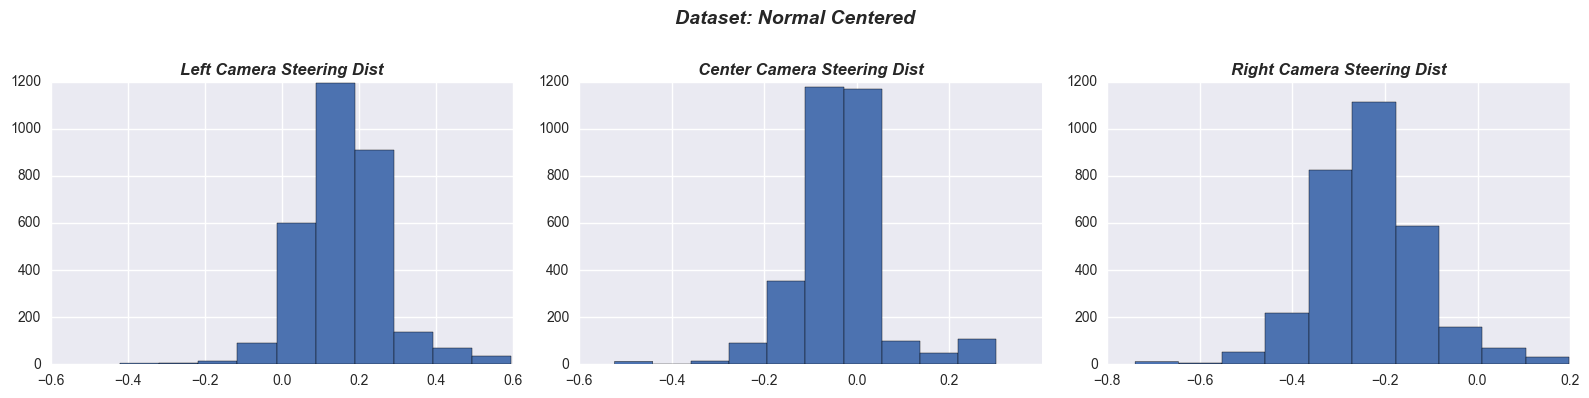

In [5]:
# plot distribution of steering angles w/small lateral shifts
def plot_steering_dist(df_dist):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,4))
    df_dist['left_steering'].hist(ax=ax1)
    df_dist['steering'].hist(ax=ax2)
    df_dist['right_steering'].hist(ax=ax3)
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': 12}
    titles = ['Left Camera Steering Dist', 'Center Camera Steering Dist', 'Right Camera Steering Dist']
    [axi.set_title(title, **params) for axi, title in zip((ax1,ax2,ax3),titles)]
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': 14}
    fig.suptitle('Dataset: {}'.format('Normal Centered'), **params)
    plt.tight_layout()
    plt.subplots_adjust(top=0.80)
    fig.savefig('./images/steering_distributions.png', transparent=False, bbox_inches='tight')
# csv produces float format for steering angles correctly    
df_track1_shift = du.lateral_shift(df_track1_center)
_ = plot_steering_dist(df_track1_shift)

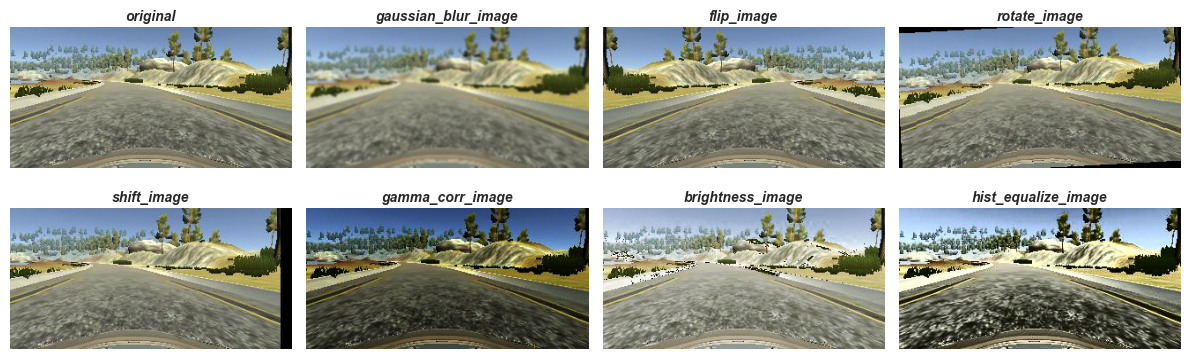

In [6]:
fig, ax = plt.subplots(2,4, figsize=(12,4))
df_center = df_track1_shift[df_track1_shift.steering == 0.0].reset_index(drop=True)
rand_idx  = np.random.randint(len(df_center))
fname, steer = df_center.ix[rand_idx].center, df_center.ix[rand_idx].steering

samples = da.aug_sample(fname, steer)
for axi, (data, steer_aug, title) in zip(ax.flatten(), samples):
    axi.imshow(mpimg.imread(data))
    set_axi_opts(axi, **{'title': title})
plt.tight_layout()
fig.savefig('./images/augmentation.png', transparent=False, bbox_inches='tight')